In [10]:
import numpy as np
import pandas as pd
import xarray as xr
import math as mt
from joblib import dump, load

import datetime

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from sklearn.model_selection import train_test_split
from random import seed
from random import randint
import statistics
from scipy.stats import stats
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time

In [2]:
# Load X and y values
X = load('./Input/X_1980-2014.joblib') 
X

y= load('./Input/y_1980-2014.joblib')
y

<xarray.DataArray 'fogdata' (time: 2170)>
array([0.32, 0.4 , 0.4 , ..., 0.76, 0.72, 0.76])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31

In [3]:
# Load X and y values
Xt = load('./Input/Xtest_2015-2018.joblib') 

yt= load('./Input/ytest_2015-2018.joblib')


In [4]:
# HyperParameter Tuning

In [11]:
svReg = SVR()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
#=20, max_depth= 3,learning_rate=0.04,
param_dist = {'kernel':[ 'rbf','poly' ,'sigmoid'  ],
              'gamma': ['scale', 'auto'],
              'C': [1,2,3,4,5,6],
              }

# run grid search
grid_search = GridSearchCV(svReg, param_grid=param_dist,scoring='r2',cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 78.67 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.088 (std: 0.379)
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.088 (std: 0.380)
Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.023 (std: 0.411)
Parameters: {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}



Accuracy of base SVR model is , 0.76249590162833


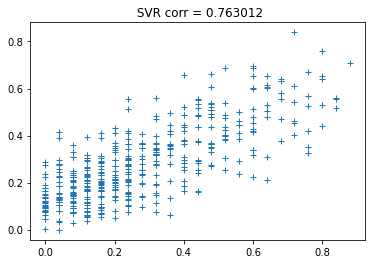

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regressor = SVR(C= 1, gamma='scale', kernel= 'rbf')
regressor.fit(X_train, y_train)
acc_svr       = round(regressor.score(X_test, y_test) * 100, 2)
print("Accuracy of base SVR model is ,",(acc_svr/100)**0.5)
yy_test = regressor.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' SVR corr = %f'%test_corr)
plt.plot(y_test,yy_test,'+')

In [13]:
regLin=SVR().fit(X, y)

Accuracy of base Linear Regression model is , 0.5278257288158659


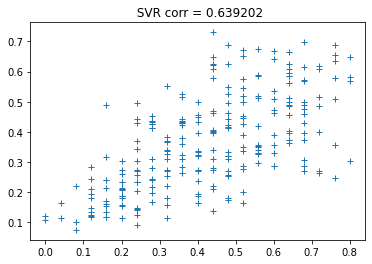

In [14]:
yPred = regLin.predict(Xt)
testcorr = np.corrcoef(yPred,yt)[0,1]
acc_svr       = round(regLin.score(Xt, yt) * 100, 2)
print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)
plt.title(' SVR corr = %f'%testcorr)
plt.plot(yt,yPred,'+')

In [15]:
yLR=regLin.predict(X)

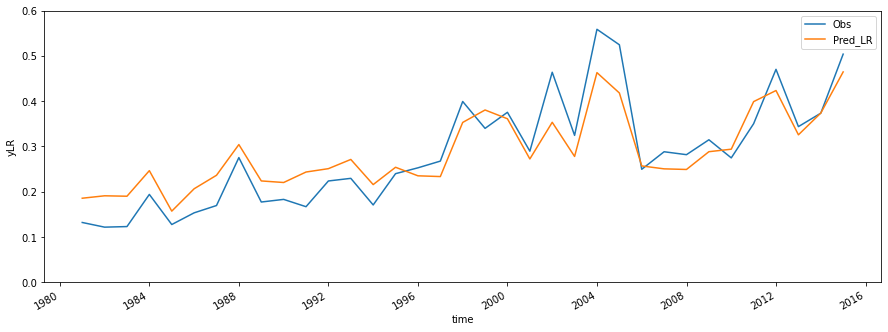

In [16]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR)}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataLR.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_LR')
plt.ylim(0, 0.6)
plt.legend()


In [17]:
ynf=y.where(y<=0.44, drop=True)
ynf

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<=0.44,drop=True)

yWd=y.where(y>0.44, drop=True)
yWd

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>0.44,drop=True)




Text(0.5, 1.0, 'Linear Regression')

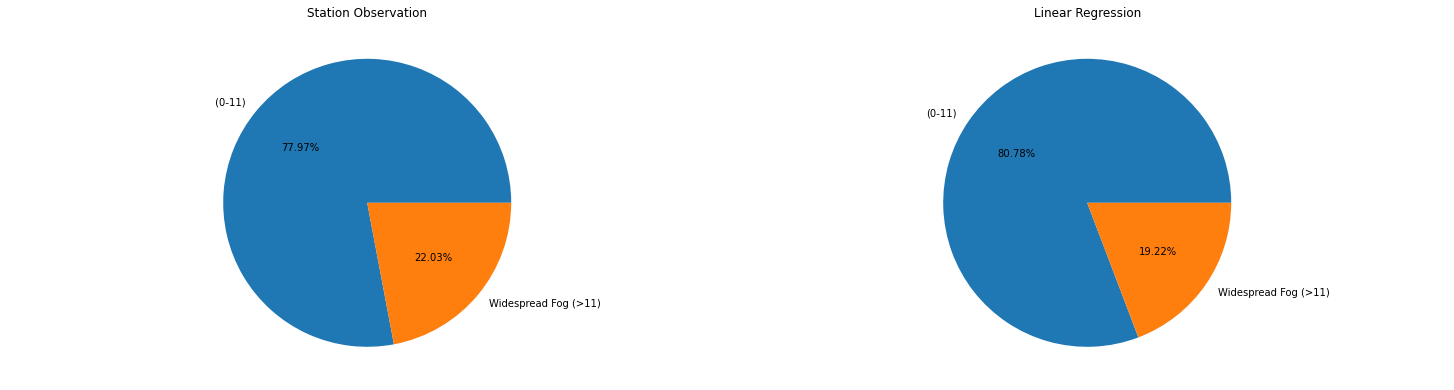

In [18]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = [' (0-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')
ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['(0-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('Linear Regression')

In [19]:
yLRt=regLin.predict(Xt)

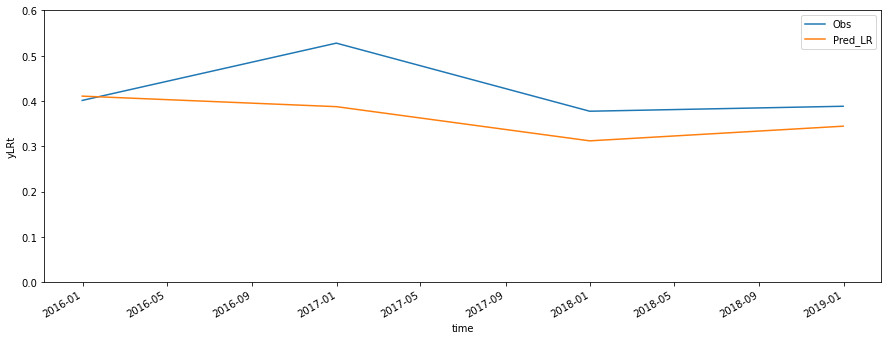

In [20]:
y_predLin_dst=xr.Dataset({'yLRt': (('time'), yLRt)}, coords={'time': yt.time})
dump(y_predLin_dst.yLRt,'TS2dataLR.joblib')
plt.figure(figsize=[15,5])
yt.resample(time='1Y').mean().plot(label='Obs')
y_predLin_dst.resample(time='1Y').mean().yLRt.plot(label='Pred_LR')
plt.ylim(0, 0.6)
plt.legend()

In [21]:
ynft=yt.where(yt<=0.44, drop=True)
ynft

yLRnft=y_predLin_dst.where(y_predLin_dst.yLRt<=0.44,drop=True)

yWdt=yt.where(yt>0.44, drop=True)
yWdt

yLRWdt=y_predLin_dst.where(y_predLin_dst.yLRt>0.44,drop=True)




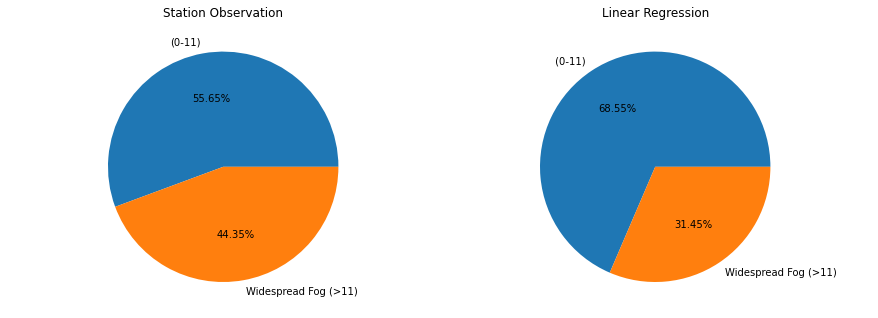

In [22]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['(0-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = [' (0-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('Linear Regression')
plt.show()
